In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, KFold
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor

In [2]:
df = pd.read_csv('preprocessed_residential_apartment.csv')
dff = df.copy()

In [3]:
df.shape

(7830, 14)

In [4]:
input_cols = ['CITY', 'FLOOR_CATEGORY', 'BUILDING_TYPE', 'CORNER_PROPERTY', 'FURNISH_LABEL',
             'BEDROOM_NUM', 'BATHROOM_NUM', 'BALCONY_NUM', 'AREA']
target_cols = ['PRICE']

In [5]:
X = df[input_cols]
y = df[target_cols]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape

((6264, 9), (1566, 9))

In [6]:
preprocessing = ColumnTransformer([
    ('oe', OrdinalEncoder(), [1, 2]),
    ('ohe', OneHotEncoder(), [0, 3, 4]),
    ('ss', StandardScaler(), [5, 6, 7, 8])
], remainder='passthrough')

pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('model', KNeighborsRegressor(n_jobs=-1))
])

# pipeline.fit(X_train, y_train)

# Define the parameter grid to search
param_grid = {
    'model__n_neighbors': range(1, 101, 10),  # Search from 1 to 100 neighbors
    'model__weights': ['uniform', 'distance'],
    'model__leaf_size': [10, 20, 30, 40, 50],  # Example values for leaf_size,
#     'model__p': [1, 2, 3]
}

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)


# Set up GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=KFold(n_splits=5, shuffle=True, random_state=42),
                           scoring={'RMSE': rmse_scorer, 'r2': 'r2'}, 
                           refit='RMSE', # Refit using the best RMSE score
                           return_train_score=True,
                           n_jobs=-1)

# Perform the search
grid_search.fit(X_train, y_train)

# Best parameter set
print("Best parameters found: ")
print(grid_search.best_params_)

# Results of the grid search
results = pd.DataFrame(grid_search.cv_results_)

Best parameters found: 
{'model__leaf_size': 10, 'model__n_neighbors': 21, 'model__weights': 'distance'}


In [7]:
{'model__leaf_size': 10, 'model__n_neighbors': 21, 'model__weights': 'uniform'}

{'model__leaf_size': 10, 'model__n_neighbors': 21, 'model__weights': 'uniform'}

In [8]:
y_train_pred = grid_search.predict(X_train)
y_test_pred = grid_search.predict(X_test)

print('Train RMSE: ', mean_squared_error(y_train, y_train_pred)**0.5)
print('Test RMSE: ', mean_squared_error(y_test, y_test_pred)**0.5)

print('Train R2: ', r2_score(y_train, y_train_pred))
print('Test R2: ', r2_score(y_test, y_test_pred))

Train RMSE:  435485.60268138064
Test RMSE:  2485193.4870984135
Train R2:  0.9942645125119061
Test R2:  0.8098387333365208


In [9]:
preprocessing = ColumnTransformer([
    ('oe', OrdinalEncoder(), [1, 2]),
    ('ohe', OneHotEncoder(), [0, 3, 4]),
    ('ss', StandardScaler(), [5, 6, 7, 8])
], remainder='passthrough')

pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('model', KNeighborsRegressor(n_neighbors=21, weights='uniform', leaf_size=10 ,n_jobs=-1))
])

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

cv = KFold(n_splits=10, shuffle=True, random_state=42)
cv_results = cross_validate(pipeline, X_train, y_train, n_jobs=-1,
                            scoring={'RMSE': rmse_scorer, 'r2': 'r2'},
                            cv=cv,
                            return_train_score=True)

In [10]:
def get_error_df(cv_results):
    return pd.DataFrame(cv_results)[list(cv_results.keys())[-4:]].apply(abs)

In [11]:
def get_error_graph(errors_df):
    fig, ax1 = plt.subplots()

    # Plotting RMSE
    color = 'tab:red'
    ax1.set_xlabel('Fold')
    ax1.set_ylabel('RMSE', color=color)
    ax1.plot(errors_df.index, errors_df['test_RMSE'], color=color, label='Test RMSE', marker='o')
    ax1.plot(errors_df.index, errors_df['train_RMSE'], color=color, label='Train RMSE', marker='x', linestyle='--')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend(loc='center left')

    # Create a twin Axes sharing the same x-axis for R^2 score
    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel('R^2 score', color=color)  
    ax2.plot(errors_df.index, errors_df['test_r2'], color=color, label='Test R^2', marker='o')
    ax2.plot(errors_df.index, errors_df['train_r2'], color=color, label='Train R^2', marker='x', linestyle='--')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.legend(loc='center right')

    # Fine-tune figure; make subplots close to each other and hide x ticks for all but bottom plot.
    fig.tight_layout()  
    plt.title('Model Evaluation Metrics per Fold')
    plt.show()

In [12]:
error_df = get_error_df(cv_results)

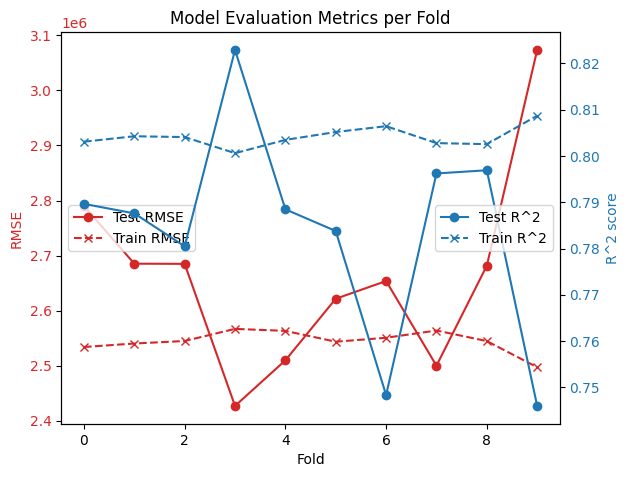

In [13]:
get_error_graph(get_error_df(cv_results))

In [14]:
print('Train RMSE: ', error_df.mean().iloc[1], '   Train RMSE STD: ', error_df.std().iloc[1])
print('Test RMSE: ', error_df.mean().iloc[0], '   Test RMSE STD: ', error_df.std().iloc[0])

print('Train R2: ', error_df.mean().iloc[3], '   Train R2 STD: ', error_df.std().iloc[3])
print('Test R2: ', error_df.mean().iloc[2], '   Test R2 STD: ', error_df.std().iloc[2])

Train RMSE:  2544880.3932427885    Train RMSE STD:  20104.125384064177
Test RMSE:  2662754.205204056    Test RMSE STD:  180655.67031171703
Train R2:  0.8041190767176308    Train R2 STD:  0.0022514419672943356
Test R2:  0.7840345982448793    Test R2 STD:  0.022668569072194316


## Best Params

In [15]:
df = pd.read_csv('preprocessed_residential_apartment.csv')
dff = df.copy()

df.shape

input_cols = ['CITY', 'FLOOR_CATEGORY', 'BUILDING_TYPE', 'CORNER_PROPERTY', 'FURNISH_LABEL',
             'BEDROOM_NUM', 'BATHROOM_NUM', 'BALCONY_NUM', 'AREA']

target_cols = ['PRICE']

X = df[input_cols]
y = df[target_cols]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


preprocessing = ColumnTransformer([
    ('oe', OrdinalEncoder(), [1, 2]),
    ('ohe', OneHotEncoder(), [0, 3, 4]),
    ('ss', StandardScaler(), [5, 6, 7, 8])
], remainder='passthrough')

pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('model', KNeighborsRegressor(n_neighbors=21, weights='uniform', leaf_size=10 ,n_jobs=-1))
])

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

pipeline.fit(X_train, y_train)

y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

print('Train RMSE: ', mean_squared_error(y_train, y_train_pred)**0.5)
print('Test RMSE: ', mean_squared_error(y_test, y_test_pred)**0.5)

print('Train R2: ', r2_score(y_train, y_train_pred))
print('Test R2: ', r2_score(y_test, y_test_pred))

Train RMSE:  2537008.4111287678
Test RMSE:  2611658.153436794
Train R2:  0.8053445590226581
Test R2:  0.7899927399268293


## Feature Reduction

In [16]:
df = pd.read_csv('preprocessed_residential_apartment.csv')

input_cols = ['CITY', 'BUILDING_TYPE', 'FURNISH_LABEL', 'BEDROOM_NUM', 'BATHROOM_NUM', 'BALCONY_NUM', 'AREA']
target_cols = ['PRICE']

X = df[input_cols]
y = df[target_cols]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


preprocessing = ColumnTransformer([
    ('oe', OrdinalEncoder(), [1]),
    ('ohe', OneHotEncoder(), [0, 2]),
    ('ss', StandardScaler(), [3, 4, 5, 6])
], remainder='passthrough')


pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('model', KNeighborsRegressor(n_jobs=-1))
])

# pipeline.fit(X_train, y_train)

# Define the parameter grid to search
param_grid = {
    'model__n_neighbors': range(1, 101, 10),  # Search from 1 to 100 neighbors
    'model__weights': ['uniform', 'distance'],
    'model__leaf_size': [10, 20, 30, 40, 50],  # Example values for leaf_size,
#     'model__p': [1, 2, 3]
}

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)


# Set up GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=KFold(n_splits=5, shuffle=True, random_state=42),
                           scoring={'RMSE': rmse_scorer, 'r2': 'r2'}, 
                           refit='RMSE', # Refit using the best RMSE score
                           return_train_score=True,
                           n_jobs=-1)

# Perform the search
grid_search.fit(X_train, y_train)

# Best parameter set
print("Best parameters found: ")
print(grid_search.best_params_)

# Results of the grid search
results = pd.DataFrame(grid_search.cv_results_)

Best parameters found: 
{'model__leaf_size': 10, 'model__n_neighbors': 31, 'model__weights': 'distance'}


In [17]:
y_train_pred = grid_search.predict(X_train)
y_test_pred = grid_search.predict(X_test)

print('Train RMSE: ', mean_squared_error(y_train, y_train_pred)**0.5)
print('Test RMSE: ', mean_squared_error(y_test, y_test_pred)**0.5)

print('Train R2: ', r2_score(y_train, y_train_pred))
print('Test R2: ', r2_score(y_test, y_test_pred))

Train RMSE:  674761.3094031654
Test RMSE:  2391940.380397073
Train R2:  0.9862303443990528
Test R2:  0.8238420088419125


In [18]:
preprocessing = ColumnTransformer([
    ('oe', OrdinalEncoder(), [1]),
    ('ohe', OneHotEncoder(), [0, 2]),
    ('ss', StandardScaler(), [3, 4, 5, 6])
], remainder='passthrough')


pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('model', KNeighborsRegressor(n_neighbors=21, weights='uniform', leaf_size=10 ,n_jobs=-1))
])

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

cv = KFold(n_splits=10, shuffle=True, random_state=42)
cv_results = cross_validate(pipeline, X_train, y_train, n_jobs=-1,
                            scoring={'RMSE': rmse_scorer, 'r2': 'r2'},
                            cv=cv,
                            return_train_score=True)

In [19]:
error_df = get_error_df(cv_results)

In [20]:
print('Train RMSE: ', error_df.mean().iloc[1], '   Train RMSE STD: ', error_df.std().iloc[1])
print('Test RMSE: ', error_df.mean().iloc[0], '   Test RMSE STD: ', error_df.std().iloc[0])

print('Train R2: ', error_df.mean().iloc[3], '   Train R2 STD: ', error_df.std().iloc[3])
print('Test R2: ', error_df.mean().iloc[2], '   Test R2 STD: ', error_df.std().iloc[2])

Train RMSE:  2435727.494427155    Train RMSE STD:  18828.140721197666
Test RMSE:  2550842.6417842987    Test RMSE STD:  155099.25499205312
Train R2:  0.8205612438595635    Train R2 STD:  0.002080976716294931
Test R2:  0.8017908495951638    Test R2 STD:  0.01908300761308856


## Final

In [21]:
df = pd.read_csv('preprocessed_residential_apartment.csv')
dff = df.copy()

input_cols = ['CITY', 'BUILDING_TYPE', 'FURNISH_LABEL', 'BEDROOM_NUM', 'BATHROOM_NUM', 'BALCONY_NUM', 'AREA']
target_cols = ['PRICE']

X = df[input_cols]
y = df[target_cols]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

preprocessing = ColumnTransformer([
    ('oe', OrdinalEncoder(), [1]),
    ('ohe', OneHotEncoder(), [0, 2]),
    ('ss', StandardScaler(), [3, 4, 5, 6])
], remainder='passthrough')

pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('model', KNeighborsRegressor(n_neighbors=30, weights='uniform', leaf_size=10 ,n_jobs=-1))
])

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

pipeline.fit(X_train, y_train)

y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

print('Train RMSE: ', mean_squared_error(y_train, y_train_pred)**0.5)
print('Test RMSE: ', mean_squared_error(y_test, y_test_pred)**0.5)

print('Train R2: ', r2_score(y_train, y_train_pred))
print('Test R2: ', r2_score(y_test, y_test_pred))

Train RMSE:  2471303.2591960127
Test RMSE:  2545082.8721963814
Train R2:  0.8152966309172218
Test R2:  0.8005631048098926
